### Imagenet

Largest image classification dataset at this point of time.

Url: http://image-net.org/

Our setup: classify from a set of 1000 classes.

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#classes' names are stored here
import pickle
classes = pickle.load(open('/content/drive/MyDrive/classes.pkl','rb'))
print (classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


### Using pre-trained model: inception
Keras has a number of models for which you can use pre-trained weights. The interface is super-straightforward:

In [4]:
import tensorflow as tf

In [5]:
import keras
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

96112376/96112376 [==============================] - 3s 0us/step


In [6]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### Predict class probabilities

In [7]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('albatross.jpg'), (299,  299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32') * 255)

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

FileNotFoundError: ignored

### Having fun with pre-trained nets

In [8]:
!wget https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg -O img.jpg

--2022-12-27 12:02:10--  https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13726 (13K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  13.40K  --.-KB/s    in 0s      

2022-12-27 12:02:10 (34.5 MB/s) - ‘img.jpg’ saved [13726/13726]



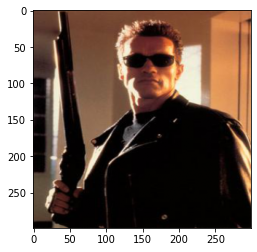

1/1 [==============================] - 8s 8s/step
top-10 classes are:
0.4340	sunglass
0.3304	sunglasses
0.0397	rifle
0.0344	trench coat
0.0138	bassoon
0.0096	assault rifle
0.0073	cloak
0.0053	electric guitar
0.0052	suit


In [9]:
img = resize(plt.imread('img.jpg'), (299,299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32') * 255.)

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))



### How do you reuse layers

Since model is just a sequence of layers, one can apply it as any other Keras model. Then you can build more layers on top of it, train them and maybe fine-tune "body" weights a bit.

In [10]:
# img = keras.layers.Input('float32',[None,299,299,3])
img = resize(plt.imread('img.jpg'), (299,299))

neck = zoo.InceptionV3(include_top=False, weights='imagenet')(img[None])

hid = keras.layers.GlobalMaxPool2D()(neck)

hid = keras.layers.Dense(512,activation='relu')(hid)

out = keras.layers.Dense(10,activation='softmax')(hid)

#<...> loss, training, etc.

87910968/87910968 [==============================] - 3s 0us/step


# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* Your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [45]:
#extract features from images
import numpy as np
from tqdm import tqdm
# from scipy.misc import imresize
from skimage.io import imread
import os
X = []
Y = []
IMAGE_W = 35
base = zoo.InceptionV3(include_top=False,pooling = 'avg', weights='imagenet')


#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in os.listdir('/content/drive/MyDrive/train/')[:1000]:
    y = fname.startswith("cat")
    img = resize(imread("/content/drive/MyDrive/train/"+fname), (299,299))
    img = zoo.inception_v3.preprocess_input(img[None].astype('float32'))
    feautures = base(img)
    Y.append(y)
    X.append(feautures)
  
  
for fname in os.listdir('/content/drive/MyDrive/train/')[15000:16000]:
    y = fname.startswith("cat")
    img = resize(imread("/content/drive/MyDrive/train/"+fname), (299,299))
    img = zoo.inception_v3.preprocess_input(img[None].astype('float32'))
    feautures = base(img)
    Y.append(y)
    X.append(feautures)
  
    
    # features = neck(img[None])#<use network to process the image into features>


In [46]:
import numpy as np
from numpy import asarray

X = np.asarray(X).astype('float32')
Y =np.array(Y).astype('float32')

In [47]:
X = np.concatenate(X, axis = 0) #stack all [1xfeatures] matrices into one. 
# assert X.ndim==2

#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
# Y = Y[:len(X)]
X.shape

(2000, 2048)

In [ ]:
#  from keras.layers import  Conv2D, MaxPool2D, Flatten, Dense
#  from keras import Sequential

#  model = Sequential()
# #  model.add(Flatten())
#  model.add(Dense(128, activation='relu'))
#  model.add(Dense(64, activation='relu'))

#  model.add(Dense(1, activation='sigmoid'))

In [ ]:
# model.compile(optimizer = keras.optimizers.Adam(learning_rate = 5e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# model.fit(X,Y,batch_size = 64, epochs = 20, validation_split= 0.2)

__load our dakka__

![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [28]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by setting var_list in the optimizer
      * `opt = tf.train.AdamOptimizer(learning_rate=...)`
      * `opt.minimize(loss,var_list=variables_you_wanna_train)`
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * you can create two update operations
      * `opt1 = tf.train.AdamOptimizer(learning_rate=lr1)`
      * `opt1.minimize(loss,var_list=head_weights)`
      * `opt2 = tf.train.AdamOptimizer(learning_rate=lr2)`
      * `opt2.minimize(loss,var_list=body_weights)`
 
### Grading
* 95% accuracy on test yields 100 points
* -10 points per 5% less accuracy

### Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 96%/97%/98%/99%/99.5% test score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [90]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_tr,X_test ,Y_tr, Y_test =train_test_split(X,Y, random_state = 1)
X_tr = sc.fit_transform(X_tr)
X_test = sc.transform(X_test)
# clf = SVC( kernel='linear',verbose= True, C = 1.5)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_tr,Y_tr)
y_pred = clf.predict(X_test)

# >>> clf.set_params(kernel='rbf').fit(X, y)
# SVC()
# >>> clf.predict(X[:5])

In [91]:
# Y_test

In [92]:
count = 0
for i in range(len(Y_test)):
  if Y_test[i] == round(y_pred[i]):
    # print(Y)
    count += 1
print(count/len(Y_test)*100)

70.8


In [76]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred)

0.708

In [77]:
from sklearn.tree import DecisionTreeClassifier

clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_tr, Y_tr)

DecisionTreeClassifier(random_state=0)

In [78]:
y_pred = clf2.predict(X_test)

In [79]:
accuracy_score(Y_test, y_pred)

0.586